In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import pickle
import os
import h5py
import collections as cl
from ast import literal_eval
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import random
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from deem import deem
from matplotlib.markers import MarkerStyle
import matplotlib.patches as mpatches

In [2]:
param_grid = {'LR_param': {'C':[10**k for k in range(-8, 4, 1)]}, 'scoring': 'roc_auc', 'cv': 3, 'random_state': 42}

with open("openmic_classmap_10.json", "r") as f: # only consider 10 classes of Openmic dataset
    openmic_class_map = json.load(f)
    
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
with open("class_align.json", "r") as f: 
    class_align = json.load(f)

with open("genre_map.json", "r") as f: 
    genre_map = json.load(f)

with open("instrument_map.json", "r") as f: 
    instrument_map = json.load(f)

In [3]:
instrument_map.keys()

dict_keys(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano', 'saxophone', 'trumpet', 'violin', 'voice'])

## performance drop

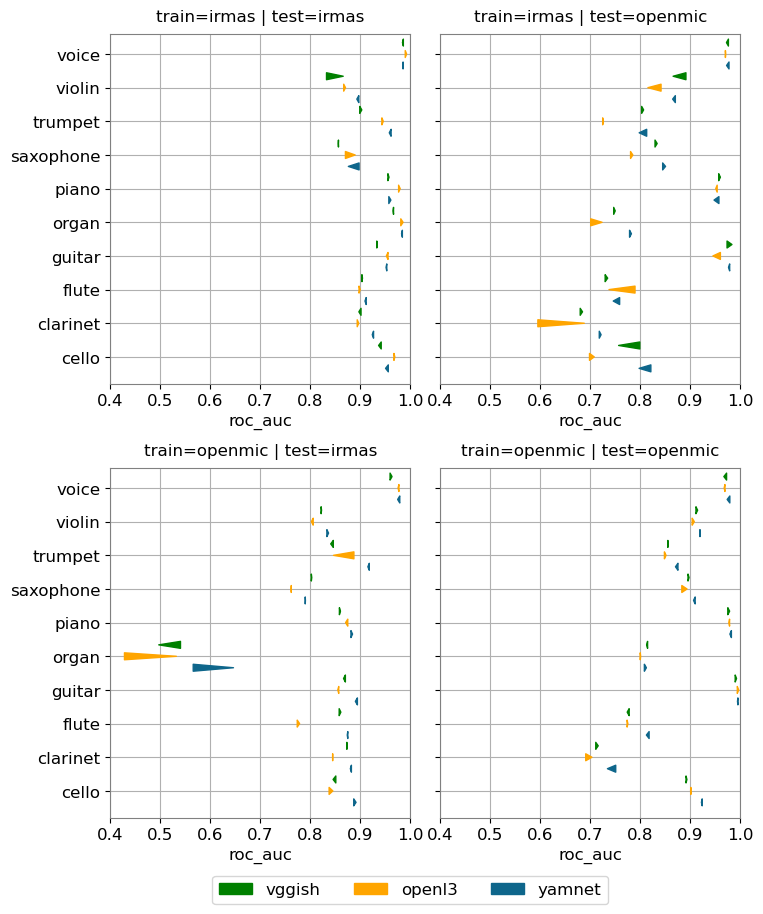

In [4]:
def plot(ax, train_set, test_set, df, lir_nonlir):

    df_visual1 = df[df['train_set']==train_set]
    df = df_visual1[df_visual1['test_set']==test_set]
    
    dist = 1
    ms1 = 20 # marker size
    line_alpha = .6; linewidth = 2
    marker_alpha = .8

    embedding_color = [('vggish', 'green'), ('openl3', 'orange'), ('yamnet', '#0e668b')]
    y_mebedding = {'vggish': np.arange(len(instrument_map)) * 5 + 1.7,
                   'openl3': np.arange(len(instrument_map)) * 5,
                   'yamnet': np.arange(len(instrument_map)) * 5 - 1.7}
           
    for embedding, color in embedding_color:
        y = y_mebedding[embedding]
        if lir_nonlir == 'linear':
            bias_lir_nonlir = [embedding, embedding+'-lda']
        else:
            bias_lir_nonlir = [embedding, embedding+'-mklda']      
            
        x = list(df[df['embedding']==bias_lir_nonlir[1]][metric])
#         ax.scatter(y=y, x=x, alpha=.8, color=color, marker='.', s=ms1, label=embedding)
        for mark in range(len(y)):
            ax.annotate('', (x[mark], y[mark]), 
                    xytext=(list(df[df['embedding']==bias_lir_nonlir[0]][metric])[mark], y[mark]), 
                        arrowprops = dict(arrowstyle="wedge,tail_width=.5", alpha=1, color=color, edgecolor=color))

    ax.set_title('train='+train_set+' | '+'test='+test_set)
    ax.set_yticks(np.arange(len(instrument_map)) * 5)
    ax.set_yticklabels(list(instrument_map.keys())) 
    ax.set_xlabel('roc_auc')
    
df = pd.read_csv('results/result_all.csv')
metric = 'roc_auc'
figure = plt.figure(figsize=(6,7))

size = 12
params = {'legend.fontsize': size,
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size,
          'ytick.labelsize': size,
          'axes.edgecolor': 'grey',
          'axes.titlepad': size*.75}
plt.rcParams.update(params)

train_set = 'openmic'; test_set = 'irmas'
ax = plt.Axes(figure, [0, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([0.4,1]); ax.set_ylim([-4,48])

# Creating legend with color box
patch1 = mpatches.Patch(color='green', label='vggish')
patch2 = mpatches.Patch(color='orange', label='openl3')
patch3 = mpatches.Patch(color='#0e668b', label='yamnet')
plt.legend(handles=[patch1, patch2, patch3], loc="lower center", ncol=3, bbox_to_anchor=(1, -0.27))
plt.grid(True)

train_set = 'openmic'; test_set = 'openmic'; 
ax = plt.Axes(figure, [0.5+.05, 0, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([0.4,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

train_set = 'irmas'; test_set = 'irmas'; 
ax = plt.Axes(figure, [0, 0.5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([0.4,1]); ax.set_ylim([-4,48]); 
plt.grid(True)

train_set = 'irmas'; test_set = 'openmic'; 
ax = plt.Axes(figure, [.5+.05, .5+.12, .5, .5])
figure.add_axes(ax); plot(ax, train_set, test_set, df, 'nonlinear'); ax.set_xlim([0.4,1]); ax.set_yticklabels([]); ax.set_ylim([-4,48])
plt.grid(True)

plt.tight_layout(); 
# plt.savefig('results/crossdataset_allresults.pdf', bbox_inches = "tight"); 
plt.savefig('results/irmas_openmic_mklda.pdf', bbox_inches = "tight")

## statistics

In [28]:
df1 = pd.read_csv('results/result_linear_all.csv')
df2 = pd.read_csv('results/result_nonlinear_all.csv')

df = df1.append(df2)

In [29]:
df

,instrument,train_set,test_set,precision,recall,f1-score,support,accuracy,roc_auc,ap,embedding
0,cello,irmas,irmas,0.301527,0.840426,0.443820,94.0,0.881152,0.941977,0.604216,vggish
1,clarinet,irmas,irmas,0.297003,0.858268,0.441296,127.0,0.834334,0.901588,0.590706,vggish
2,flute,irmas,irmas,0.331010,0.785124,0.465686,121.0,0.869148,0.903389,0.623614,vggish
3,guitar,irmas,irmas,0.558491,0.855491,0.675799,346.0,0.829532,0.927595,0.814942,vggish
4,organ,irmas,irmas,0.465318,0.925287,0.619231,174.0,0.881152,0.966627,0.759871,vggish
...,...,...,...,...,...,...,...,...,...,...,...
355,piano,openmic,irmas,0.209929,0.870588,0.338286,170.0,0.652461,0.884681,0.689572,yamnet-mklda
356,saxophone,openmic,irmas,0.236318,0.633333,0.344203,150.0,0.782713,0.795950,0.363318,yamnet-mklda
357,trumpet,openmic,irmas,0.306265,0.880000,0.454389,150.0,0.809724,0.915290,0.652681,yamnet-mklda
358,violin,openmic,irmas,0.228690,0.769231,0.352564,143.0,0.757503,0.836686,0.424961,yamnet-mklda


In [30]:
embeddings = ['vggish', 'openl3', 'yamnet', 'vggish-k', 'openl3-k', 'yamnet-k', 
              'vggish-klda', 'openl3-klda', 'yamnet-klda', 'vggish-mklda', 'openl3-mklda', 'yamnet-mklda']

case_mean_all = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])

cases = [['irmas', 'irmas'], ['openmic', 'openmic'], ['openmic', 'irmas'], ['irmas', 'openmic']]
for embedding in embeddings:
    for case in cases:
        train_set = case[0]
        test_set = case[1]
        case_mean = df.loc[(df['train_set'] == train_set) & (df['test_set'] == test_set) 
                        & (df['embedding'] == embedding)]['roc_auc'].values.mean()
        
        case_mean_item = pd.DataFrame(columns=['embedding', 'train_set', 'test_set', 'mean', 'change'])
        case_mean_item['embedding'] = [embedding]
        case_mean_item['train_set'] = [train_set]
        case_mean_item['test_set'] = [test_set]
        case_mean_item['mean'] = [case_mean]

        case_mean_all = case_mean_all.append(case_mean_item)
        # print('{}: {} -> {}, mean = {}'.format(embedding, train_set, test_set, case_mean))
# case_mean_all = case_mean_all.reset_index(drop=True)

In [31]:
case_mean_all 

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.915978,NaN
0,vggish,openmic,openmic,0.879543,NaN
0,vggish,openmic,irmas,0.82815,NaN
0,vggish,irmas,openmic,0.838124,NaN
0,openl3,irmas,irmas,0.932664,NaN
0,openl3,openmic,openmic,0.871609,NaN
0,openl3,openmic,irmas,0.805562,NaN
0,openl3,irmas,openmic,0.801629,NaN
0,yamnet,irmas,irmas,0.946498,NaN
0,yamnet,openmic,openmic,0.897392,NaN


In [32]:
for embedding in ['vggish', 'openl3', 'yamnet']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [33]:
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-k','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-k','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [34]:
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-klda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-klda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [35]:
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &  # debiased
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mklda','')) &  # original 
                        (case_mean_all['train_set'] == 'openmic') & (case_mean_all['test_set'] == 'irmas')]['mean']
    
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) & 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic'), 'change'] = \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding) &   # debiased
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean'] - \
    case_mean_all.loc[(case_mean_all['embedding'] == embedding.replace('-mklda','')) & # original 
                        (case_mean_all['train_set'] == 'irmas') & (case_mean_all['test_set'] == 'openmic')]['mean']

In [36]:
case_mean_all = case_mean_all.reset_index(drop=True)

In [37]:
case_mean_all

,embedding,train_set,test_set,mean,change
0,vggish,irmas,irmas,0.915978,NaN
1,vggish,openmic,openmic,0.879543,NaN
2,vggish,openmic,irmas,0.82815,-0.087827
3,vggish,irmas,openmic,0.838124,-0.041419
4,openl3,irmas,irmas,0.932664,NaN
5,openl3,openmic,openmic,0.871609,NaN
6,openl3,openmic,irmas,0.805562,-0.127102
7,openl3,irmas,openmic,0.801629,-0.06998
8,yamnet,irmas,irmas,0.946498,NaN
9,yamnet,openmic,openmic,0.897392,NaN


In [38]:
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))
    
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    print('{}, mean: {}, change: {}'.format(embedding, list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']),
                                            list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])))

vggish-k, mean: [0.924885827207723, 0.8813800411660043, 0.8207276466779406, 0.8276199965889456], change: [nan, nan, -0.007422450203262487, -0.010503837944373484]
openl3-k, mean: [0.9395383303127243, 0.8774667584180337, 0.8090643451100382, 0.8077086522602064], change: [nan, nan, 0.0035025257627102624, 0.006079944319842934]
yamnet-k, mean: [0.93768951507558, 0.8920340314824078, 0.865988903184624, 0.8383564336426303], change: [nan, nan, 0.015858606882693693, -0.016293973896922997]
vggish-klda, mean: [0.9217149036542903, 0.8806356399984512, 0.8264152328758263, 0.8368015888122435], change: [nan, nan, -0.0017348640053768127, -0.0013222457210755323]
openl3-klda, mean: [0.939501786591461, 0.8785671115790856, 0.7858654529881166, 0.8031338863798296], change: [nan, nan, -0.019696366359211348, 0.0015051784394661816]
yamnet-klda, mean: [0.9336064395252782, 0.8932526305866307, 0.8605199530423764, 0.8455681416857365], change: [nan, nan, 0.010389656740446118, -0.009082265853816884]
vggish-mklda, mean:

In [39]:
result_table = []
for embedding in ['vggish-k', 'openl3-k', 'yamnet-k']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-klda', 'openl3-klda', 'yamnet-klda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])
    
for embedding in ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']:
    result_table.append(list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['mean']) + \
                        list(case_mean_all.loc[(case_mean_all['embedding'] == embedding)]['change'])[-2:])

In [40]:
df = pd.DataFrame(columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2'])
embeddings = ['vggish-k', 'openl3-k', 'yamnet-k'] + ['vggish-klda', 'openl3-klda', 'yamnet-klda'] + \
                    ['vggish-mklda', 'openl3-mklda', 'yamnet-mklda']
for k in range(len(result_table)):
    new_line = [embeddings[k]] + list(np.round(np.array(result_table[k]) * 100, 2))

    df = df.append(pd.DataFrame([new_line], 
        columns=['embedding', 'irmas-irmas', 'openmic-openmic', 'openmic-irmas', 'irmas-openmic', 'change1', 'change2']), 
        ignore_index=True)
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic,change1,change2
0,vggish-k,92.49,88.14,82.07,82.76,-0.74,-1.05
1,openl3-k,93.95,87.75,80.91,80.77,0.35,0.61
2,yamnet-k,93.77,89.2,86.6,83.84,1.59,-1.63
3,vggish-klda,92.17,88.06,82.64,83.68,-0.17,-0.13
4,openl3-klda,93.95,87.86,78.59,80.31,-1.97,0.15
5,yamnet-klda,93.36,89.33,86.05,84.56,1.04,-0.91
6,vggish-mklda,92.22,88.03,82.4,83.49,-0.41,-0.32
7,openl3-mklda,93.95,87.87,81.24,80.52,0.69,0.35
8,yamnet-mklda,93.71,89.21,85.79,84.42,0.78,-1.05


In [41]:
df['change1'] = ['(' + str(item) + ')' for item in df['change1']]
df['change2'] = ['(' + str(item) + ')' for item in df['change2']]
df['openmic-irmas'] = [str(df['openmic-irmas'][k]) + ' ' + df['change1'][k] for k in range(len(df['change1']))]
df['irmas-openmic'] = [str(df['irmas-openmic'][k]) + ' ' + df['change2'][k] for k in range(len(df['change2']))]
df = df.drop(columns=['change1', 'change2'])
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic
0,vggish-k,92.49,88.14,82.07 (-0.74),82.76 (-1.05)
1,openl3-k,93.95,87.75,80.91 (0.35),80.77 (0.61)
2,yamnet-k,93.77,89.2,86.6 (1.59),83.84 (-1.63)
3,vggish-klda,92.17,88.06,82.64 (-0.17),83.68 (-0.13)
4,openl3-klda,93.95,87.86,78.59 (-1.97),80.31 (0.15)
5,yamnet-klda,93.36,89.33,86.05 (1.04),84.56 (-0.91)
6,vggish-mklda,92.22,88.03,82.4 (-0.41),83.49 (-0.32)
7,openl3-mklda,93.95,87.87,81.24 (0.69),80.52 (0.35)
8,yamnet-mklda,93.71,89.21,85.79 (0.78),84.42 (-1.05)


In [42]:
df.to_csv('results/result_table_nonlinear.csv', index=False)

In [43]:
df_linear = pd.read_csv('results/result_table_linear.csv')
df = df_linear.append(df)
df.to_csv('results/result_table_all.csv', index=False)

In [44]:
df

,embedding,irmas-irmas,openmic-openmic,openmic-irmas,irmas-openmic
0,vggish,91.6,87.95,82.82 (-8.78),83.81 (-4.14)
1,openl3,93.27,87.16,80.56 (-12.71),80.16 (-7.0)
2,yamnet,94.65,89.74,85.01 (-9.64),85.47 (-4.27)
3,vggish-lda,91.6,87.99,82.99 (0.18),83.82 (0.0)
4,openl3-lda,93.26,87.16,80.56 (0.01),80.14 (-0.03)
5,yamnet-lda,94.65,89.74,85.01 (0.0),85.47 (0.0)
6,vggish-mlda,91.45,87.98,82.7 (-0.11),83.3 (-0.51)
7,openl3-mlda,93.24,87.16,80.67 (0.12),79.98 (-0.18)
8,yamnet-mlda,94.65,89.74,85.01 (-0.0),85.47 (0.0)
0,vggish-k,92.49,88.14,82.07 (-0.74),82.76 (-1.05)


In [23]:
df_linear = pd.read_csv('results/result_linear_all.csv')
df_nonlinear = pd.read_csv('results/result_nonlinear_all.csv')
df = df_linear.append(df_nonlinear)
df.to_csv('results/result_all.csv', index=False)